# Ensemble: tas_siconc

## Imports & defaults

In [1]:
import libs.analysis
import libs.ensemble
import libs.local
import libs.plot
import libs.vars
import matplotlib

matplotlib.rcParams.update({ 'font.size': 18 })

/home/users/woodward/.conda/envs/climate/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Data

In [2]:
# ----- SPECIFIC SETTINGS -----
component = 'Amon'
experiment = 'ssp585'
variable_id = 'tas_siconc'

conf = [v for v in libs.vars.variables() if v['variable_id'] == variable_id][0]
time_series_text = conf['text']
time_series_weighted_method = conf['weighting_method']
time_series_units = conf['units']
time_series_y_label = f'Temperature ({time_series_units})'
time_series_y_range = (-20, 2)
time_series_y_range_full = (-30, 20)
time_series_y_range_monthly = (-30, 10)
time_series_y_range_regional = (-40, 12)
time_series_process = lambda x: x

In [3]:
ensemble, weight = libs.ensemble.get_and_preprocess(
    component, 
    experiment, 
    variable_id,
    preprocess=conf['preprocess']
)

ensemble_time_series = time_series_process(
    libs.local.get_ensemble_series(variable_id, experiment)
)
ensemble_time_series_smooth = time_series_process(
    libs.local.get_ensemble_series(variable_id, experiment, suffix='_smooth')
)

time_slices = libs.vars.default_time_slices()
ensemble_time_slices = libs.analysis.generate_slices(ensemble)

## Time series

### Mean

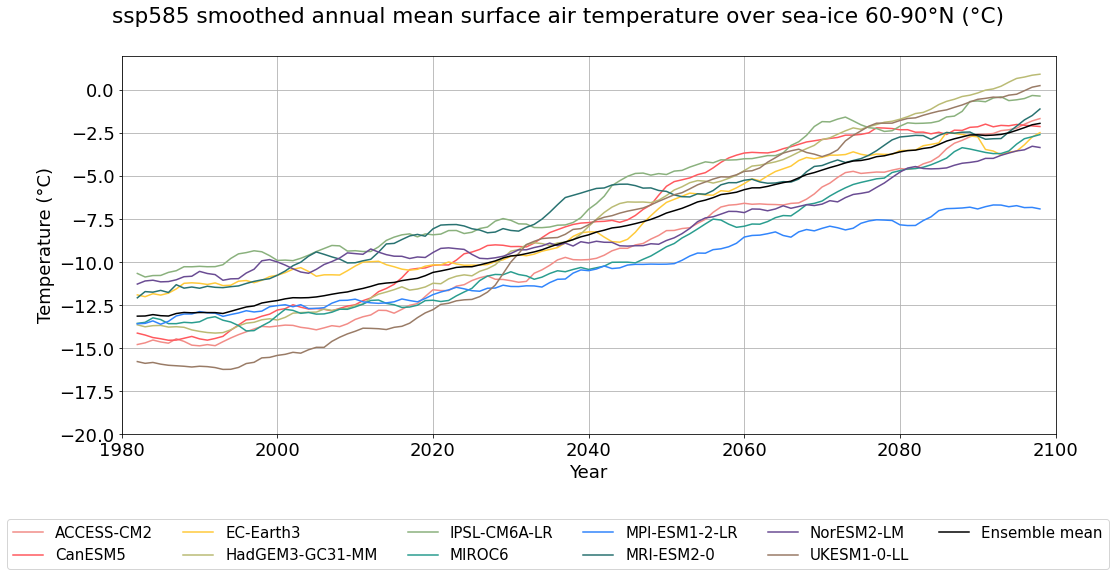

In [4]:
# libs.plot.time_series_from_vars(
#     ensemble_time_series_smooth,
#     title=f'{experiment} smoothed monthly {time_series_text} 60-90°N ({time_series_units})',
#     xattr='time',
#     ylabel=time_series_y_label,
#     yrange=time_series_y_range
# );

vars_series = [
    ensemble_time_series
]
plot_arr = []
for item in vars_series:
    item_processed = item.groupby('time.year').mean('time').rolling(year=5, center=True).mean('year')
    item_processed = libs.ensemble.calc_variable_mean(item_processed)
    plot_arr.append(item_processed)


libs.plot.time_series_from_vars(
    plot_arr,
    title=f'{experiment} smoothed annual mean {time_series_text} 60-90°N ({time_series_units})',
    xattr='year',
    ylabel=time_series_y_label,
    yrange=time_series_y_range
);

### Full variability

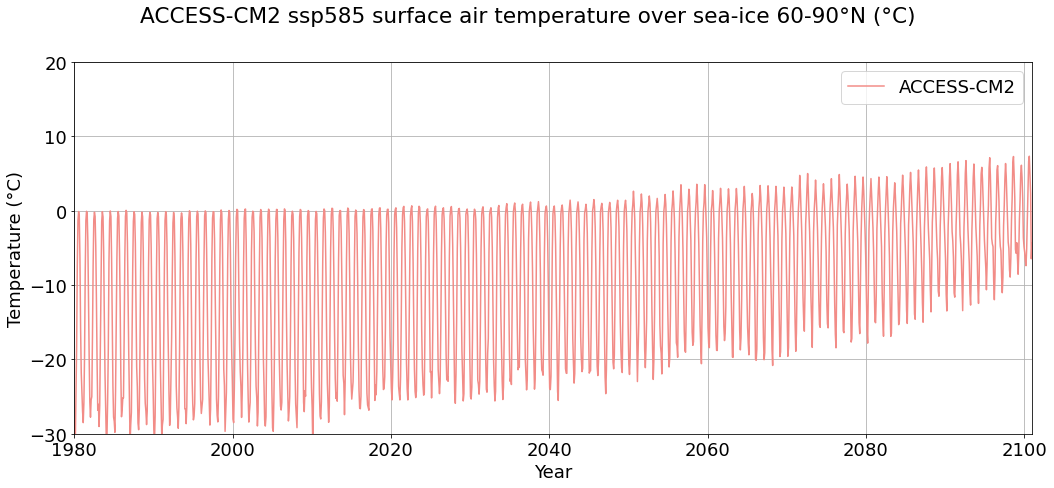

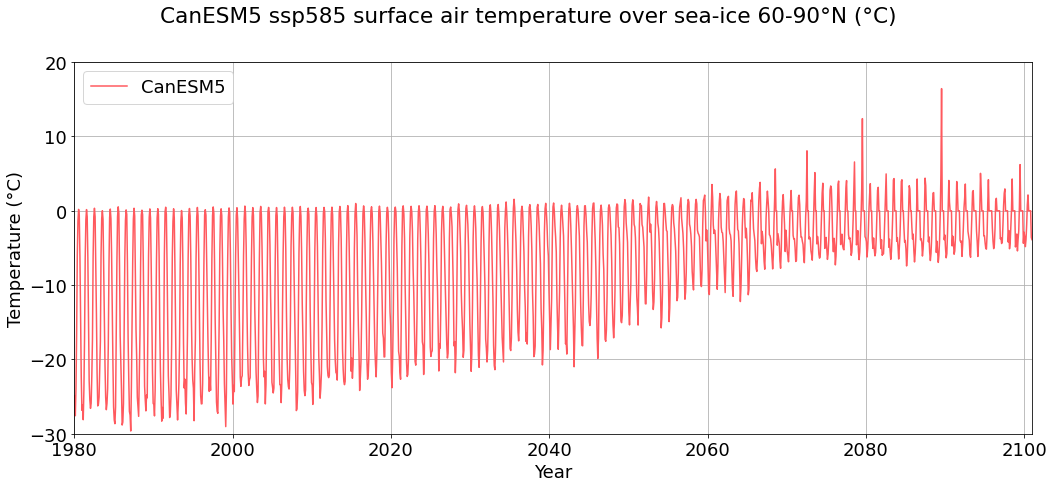

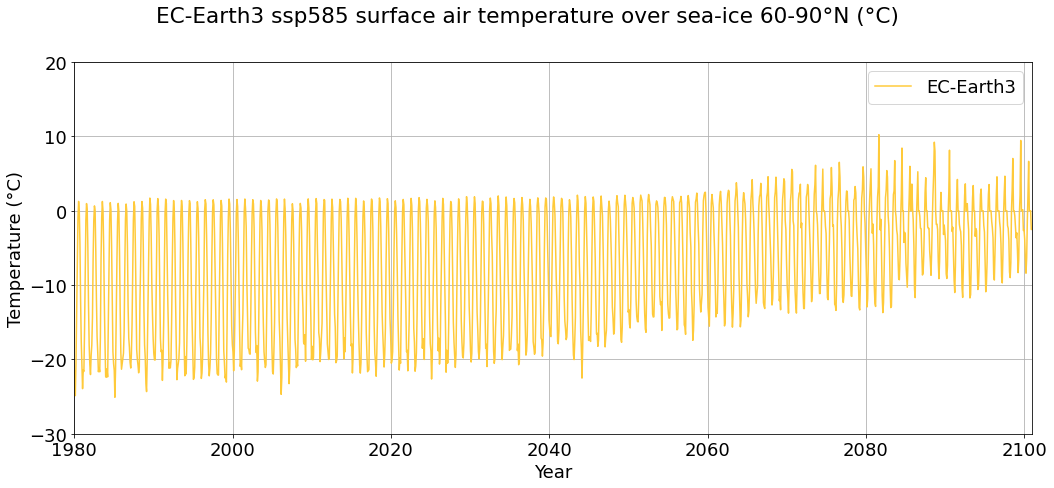

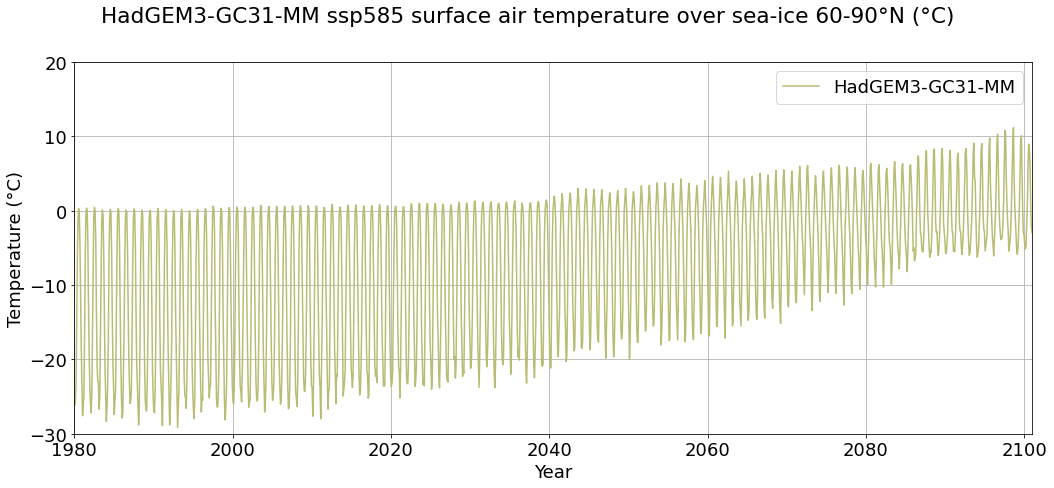

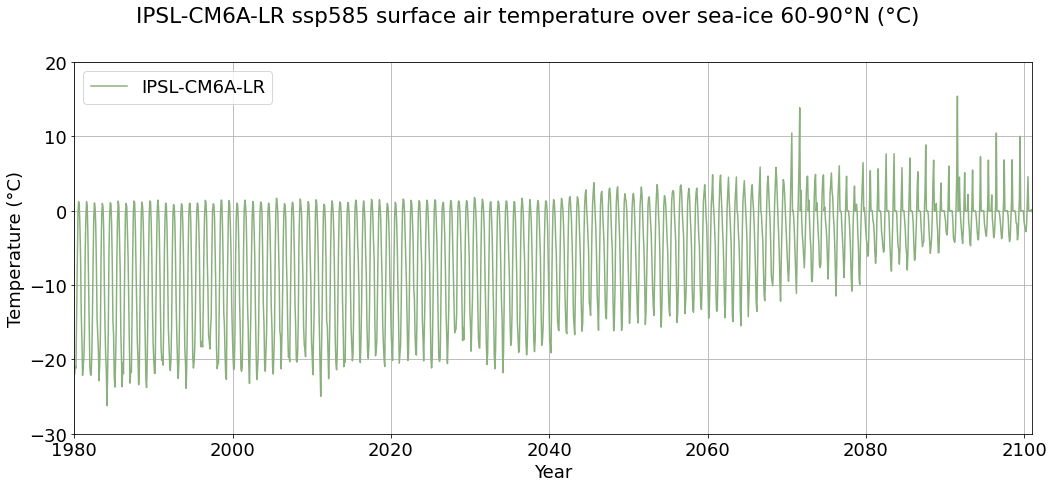

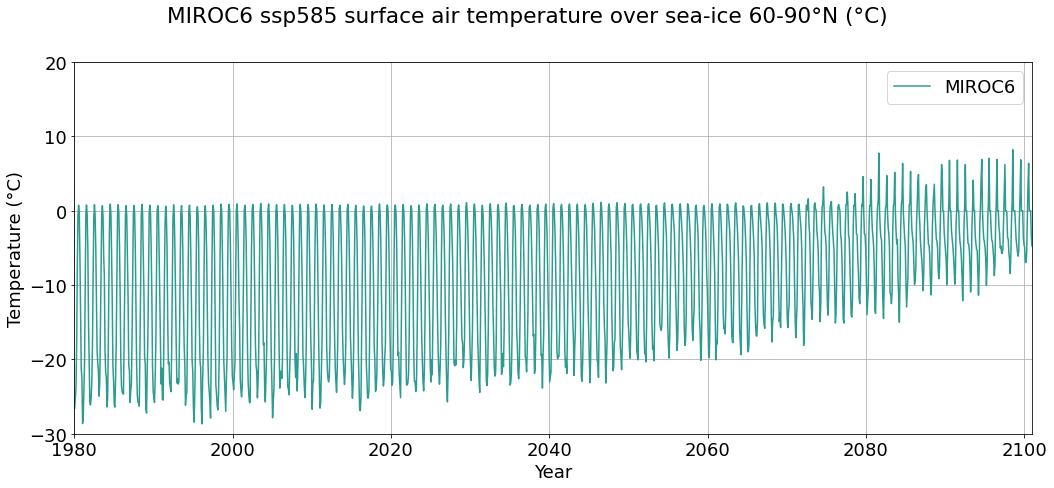

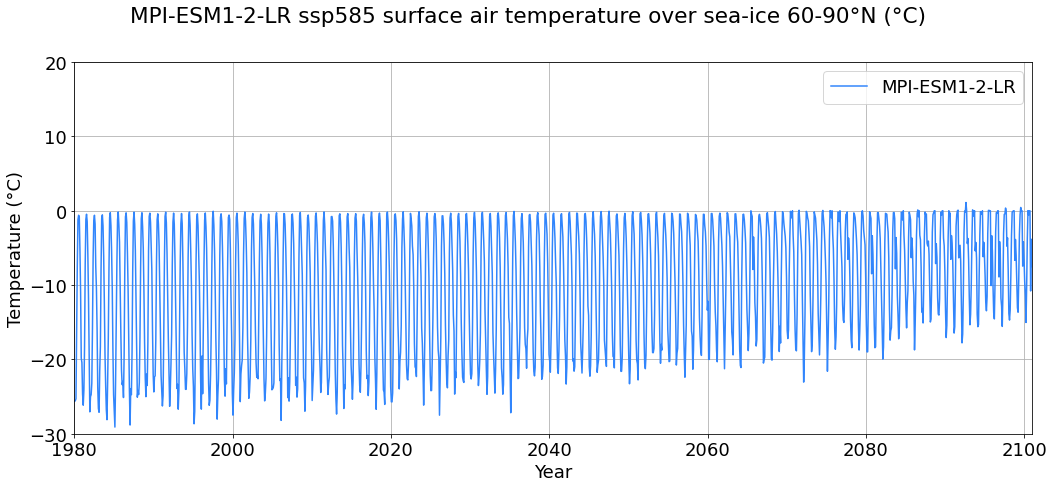

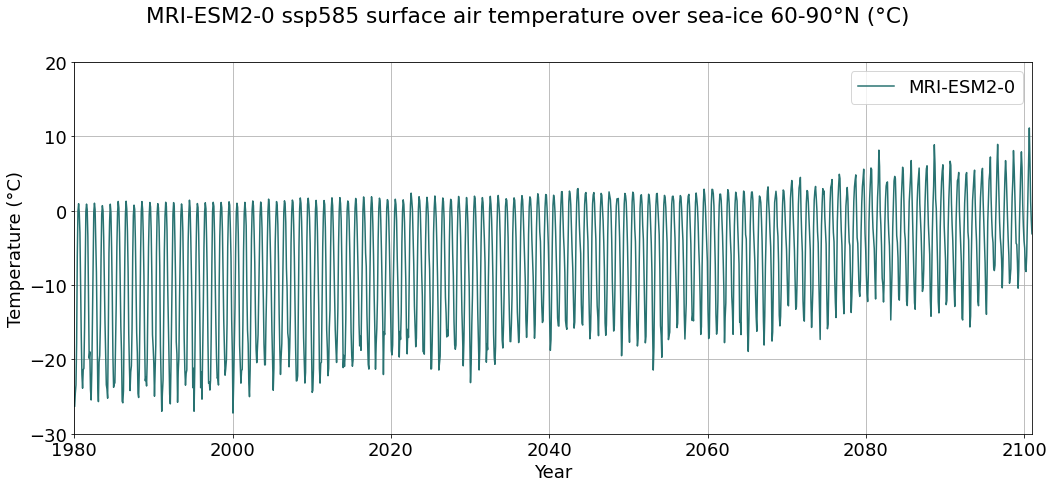

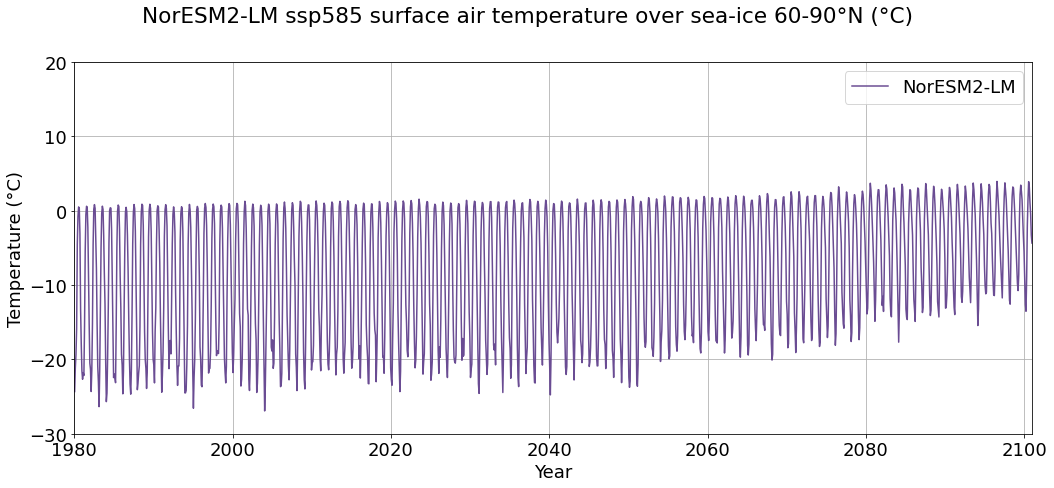

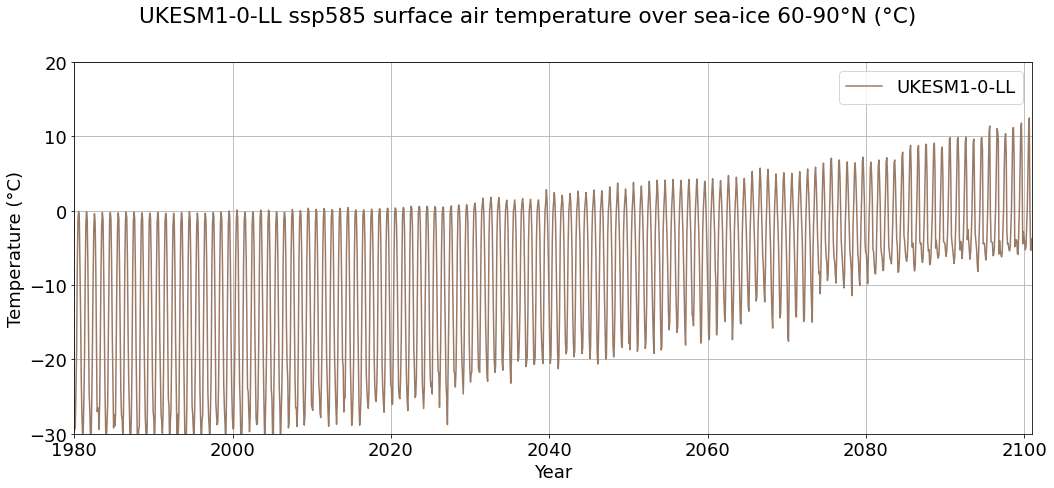

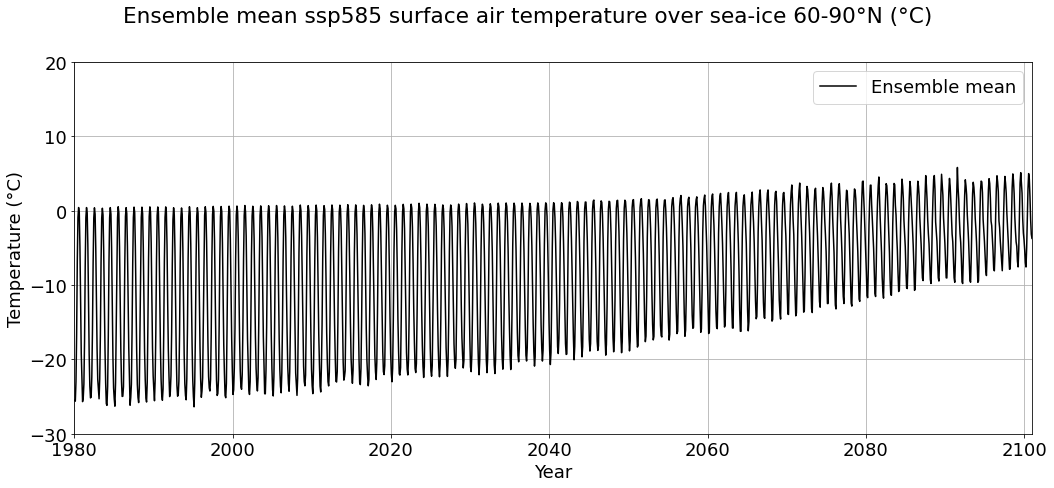

In [5]:
libs.ensemble.time_series_full_variability(
    ensemble_time_series,
    plot_kwargs={
        'title': f'{{member}} {experiment} {time_series_text} 60-90°N ({time_series_units})',
        'ylabel': time_series_y_label,
        'yrange': time_series_y_range_full
    }
)

## Monthly variability

### Full region (time)

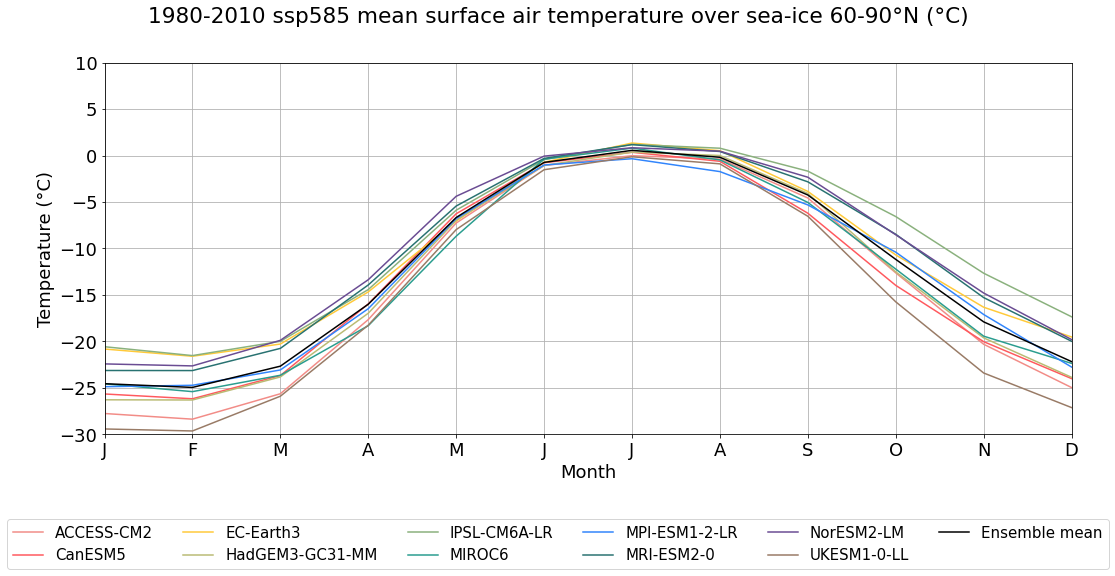

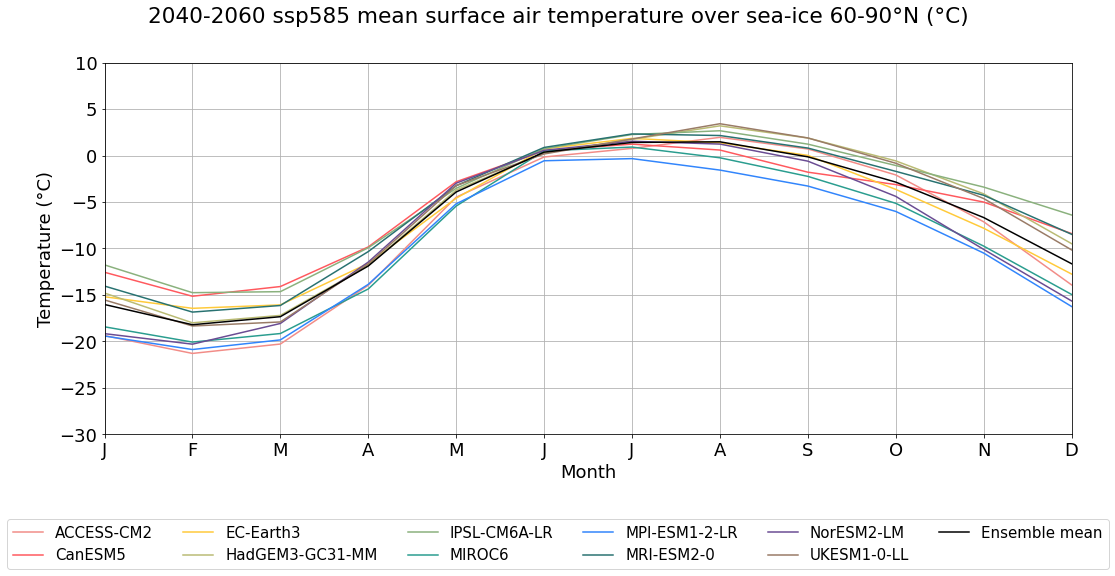

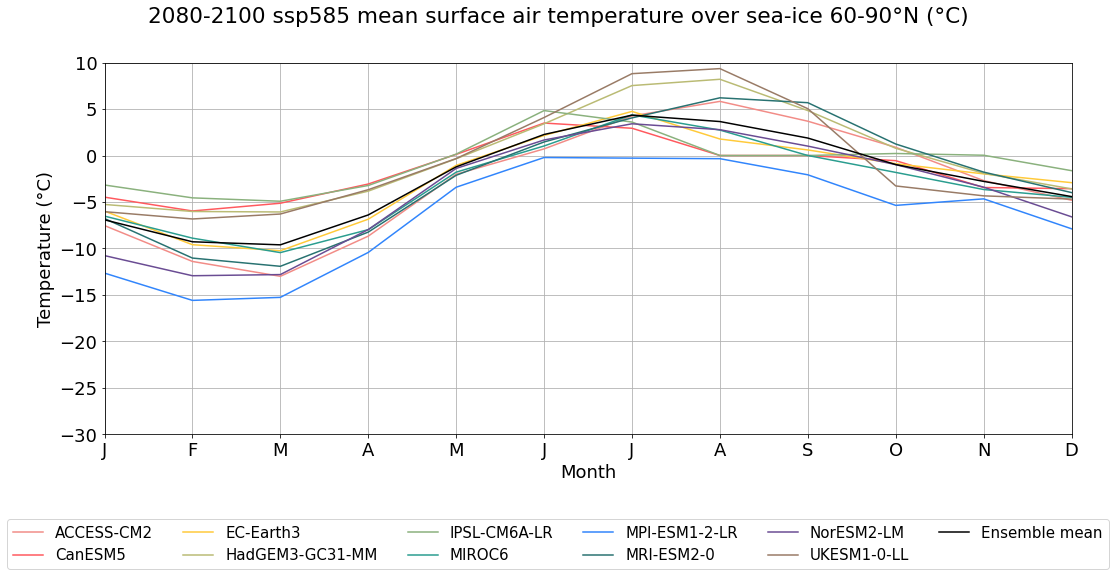

In [6]:
for s in time_slices:
    s_label = s['label']

    libs.plot.monthly_variability(
        ensemble_time_series.sel(**s['slice']).groupby('time.month').mean('time'),
        title=f'{s_label} {experiment} mean {time_series_text} 60-90°N ({time_series_units})',
        ylabel=time_series_y_label,
        yrange=time_series_y_range_monthly
    )

### Regional (time)

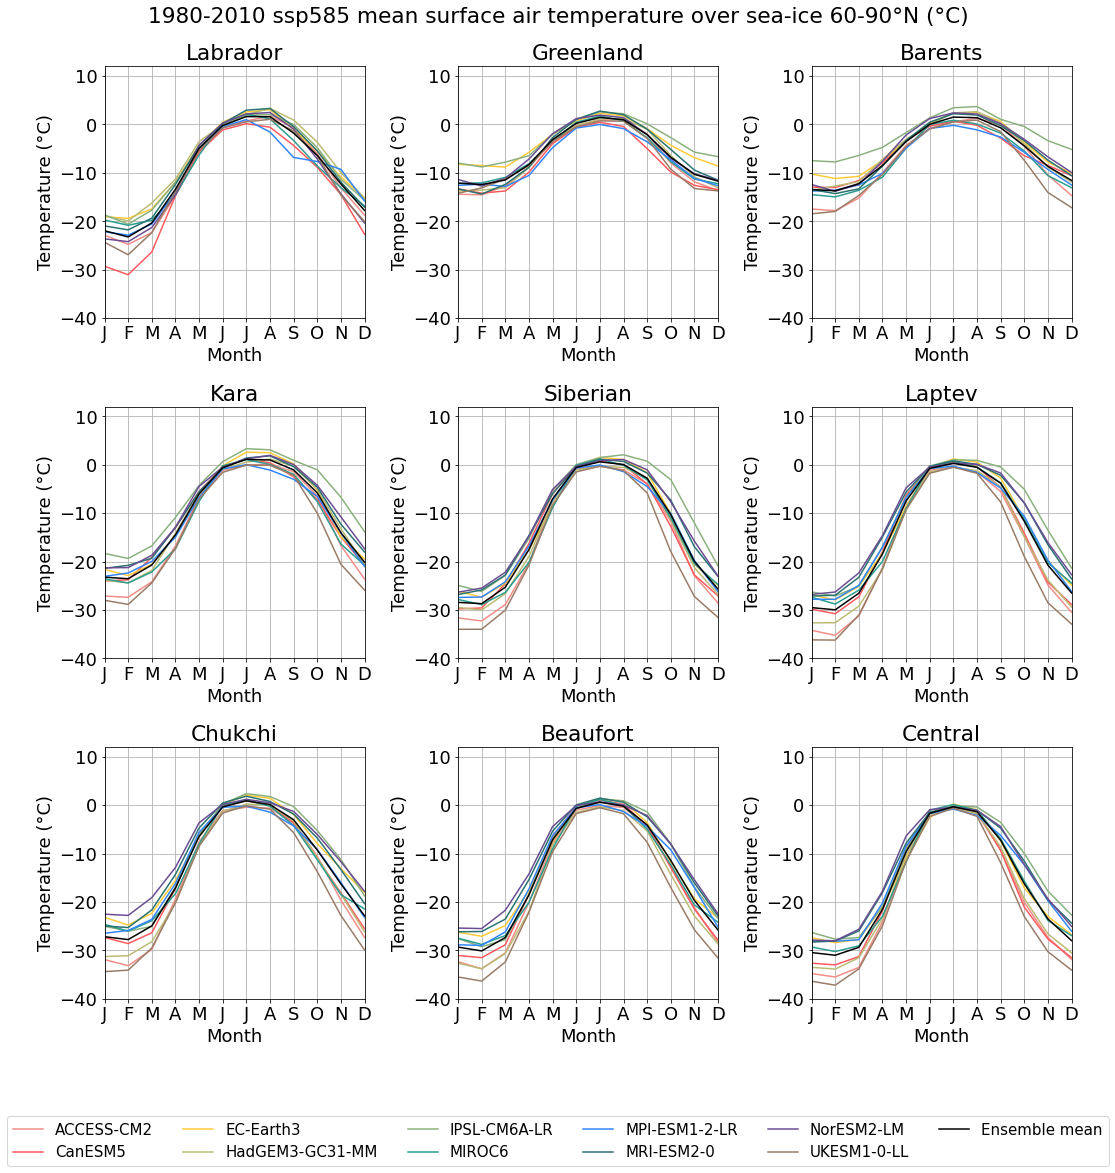

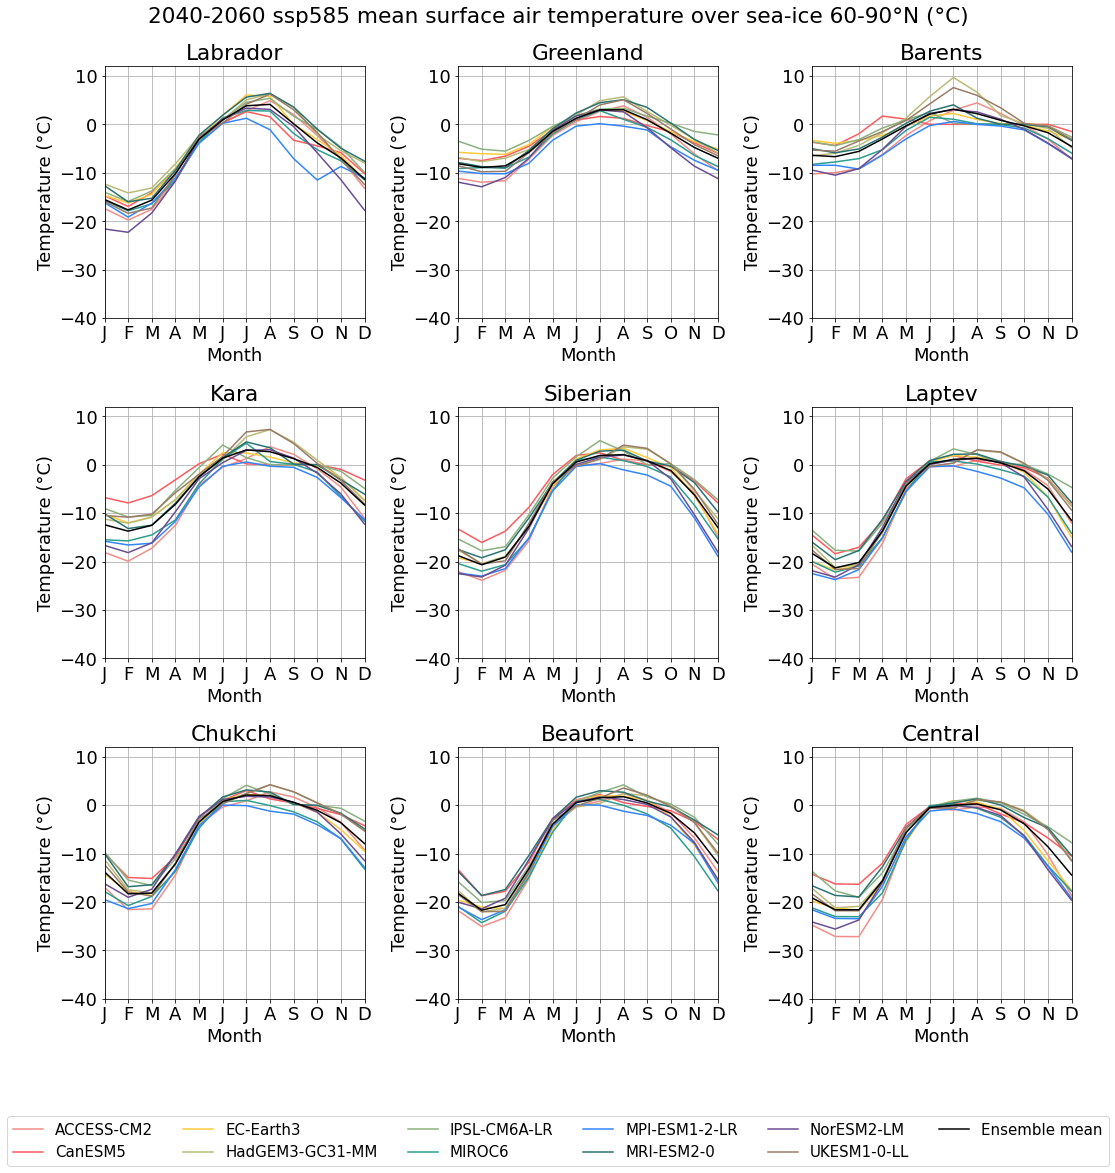

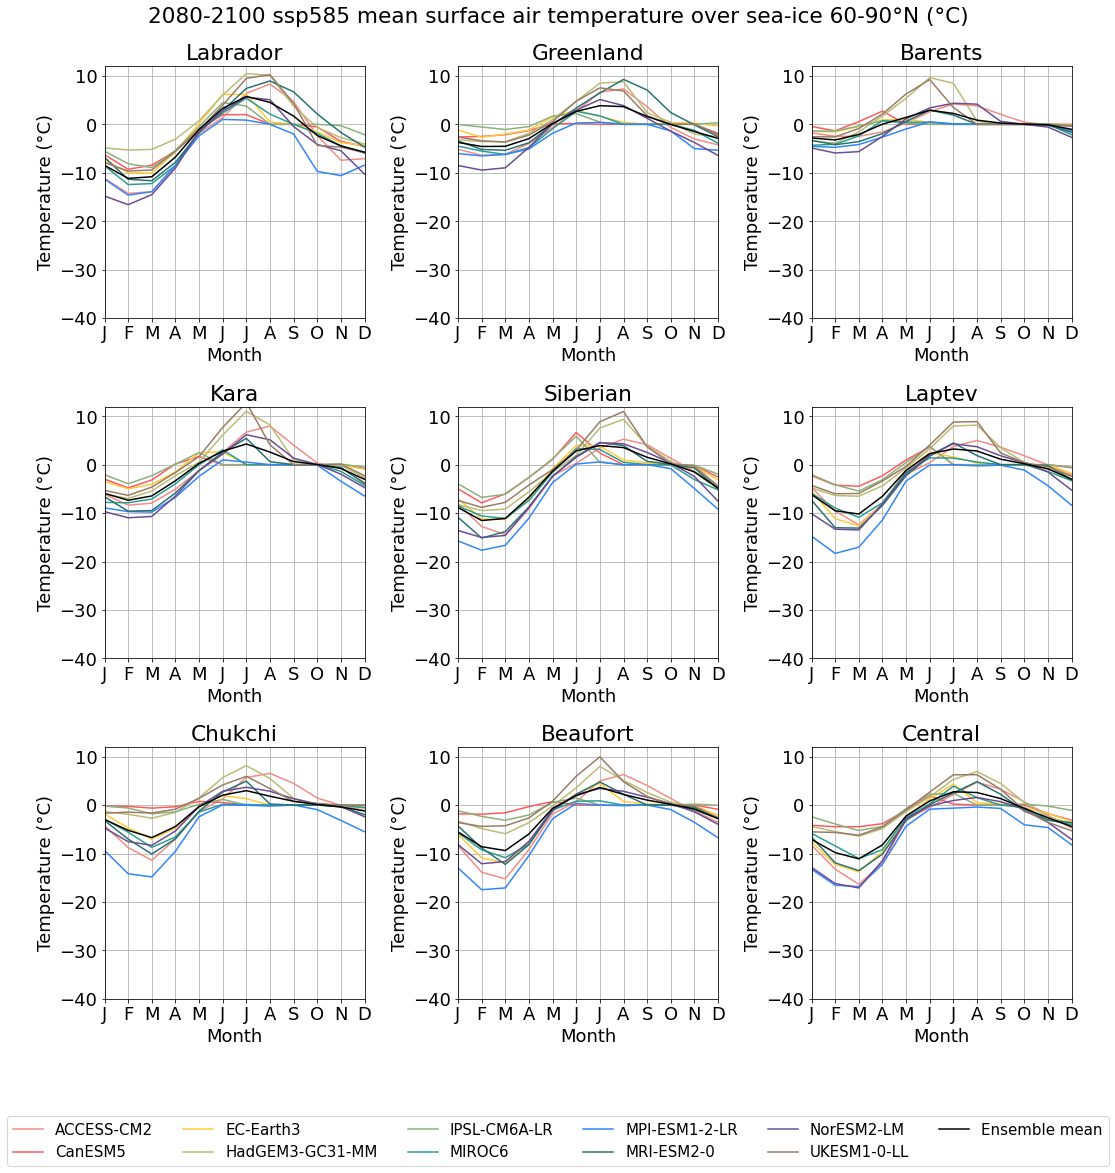

In [7]:
regions = libs.local.get_ensemble_regional_series(variable_id, experiment)

for s in time_slices:
    s_label = s['label']
    regional_time_slices = [
        time_series_process(
            data.sel(**s['slice'])
        ).groupby('time.month').mean('time') for data in regions
    ]

    libs.plot.monthly_variability_regional(
        regional_time_slices,
        title=f'{s_label} {experiment} mean {time_series_text} 60-90°N ({time_series_units})',
        ylabel=time_series_y_label,
        yrange=time_series_y_range_regional
    )

### Months above 0C

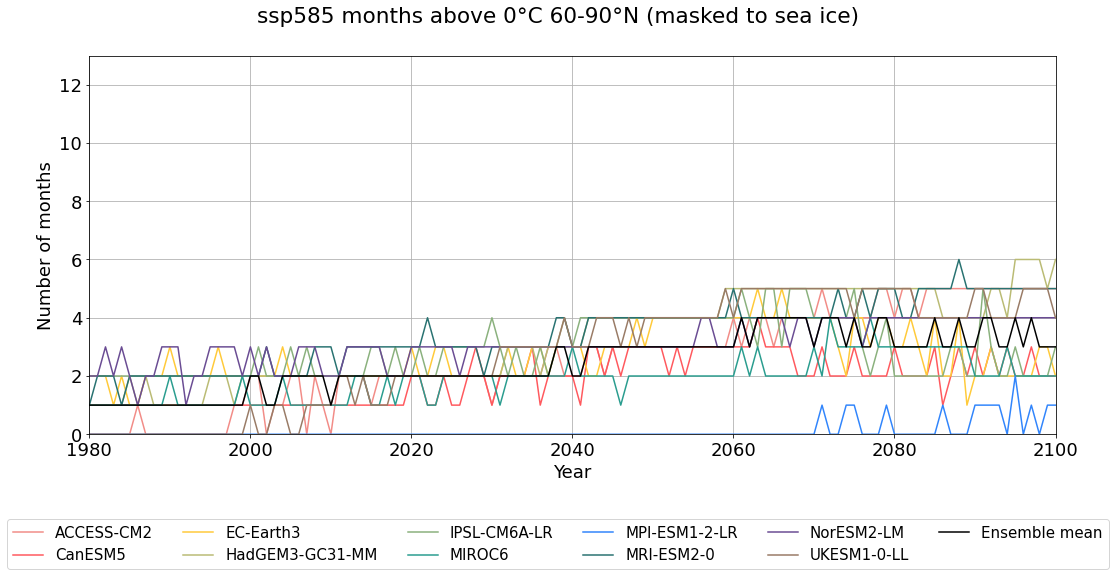

In [8]:
ensemble_melt_season_length = ensemble_time_series.copy()
ensemble_melt_season_length = ensemble_melt_season_length\
    .where(ensemble_time_series > 0)\
    .groupby('time.year')\
    .count('time')

ensemble_melt_season_length = libs.ensemble.calc_variable_mean(ensemble_melt_season_length, 'time')
ensemble_melt_season_length['Ensemble mean'] = ensemble_melt_season_length['Ensemble mean'].round()

fig = libs.plot.time_series_from_vars(
    [
        ensemble_melt_season_length
    ],
    title=f'{experiment} months above 0°C 60-90°N (masked to sea ice)',
    xattr='year',
    ylabel='Number of months',
    yrange=(0, 13)
);

#data = ensemble_rain_season_length
#data_min = data.to_array('time').min('time')
#data_max = data.to_array('time').max('time')

#fig.axes[0].fill_between(
#    data.year.values,
#    data_min.values,
#    data_max.values,
#    alpha=0.05,
#    color=data['Ensemble mean'].attrs['color'],
#    zorder=-1
#);

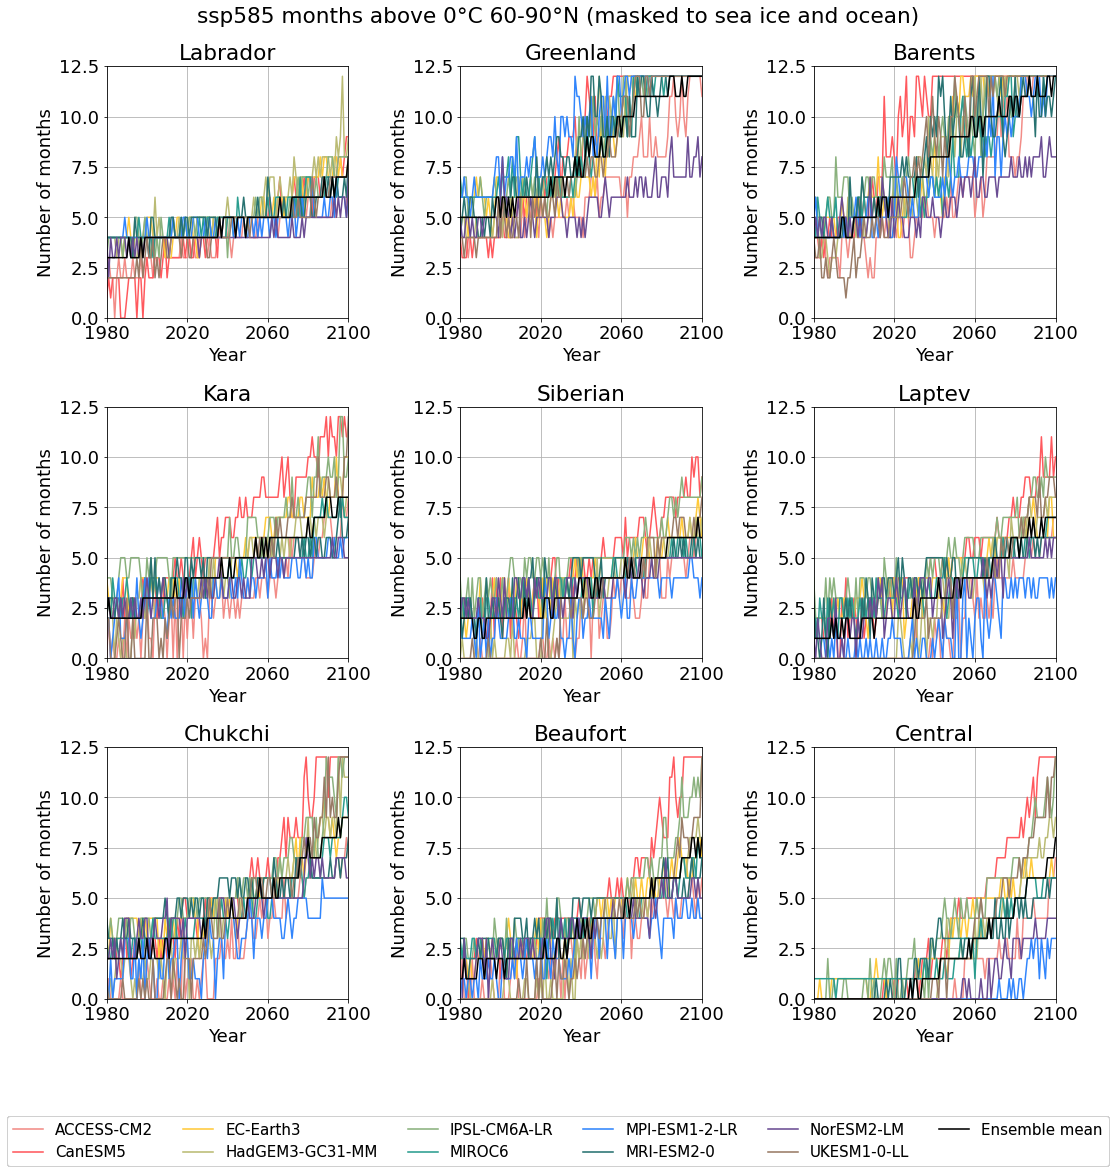

In [9]:
import matplotlib.pyplot as plt

regions = libs.local.get_ensemble_regional_series('tas', experiment)

fig, axes = plt.subplots(*(3, 3), figsize=(15, 15))
axes = axes.flatten()
fig.suptitle(f'{experiment} months above 0°C 60-90°N (masked to sea ice and ocean)')

for i, data in enumerate(regions):
    region = data.attrs['region']
    data_processed = data.where(data > 0).groupby('time.year').count('time')

#     for key in ensemble_rain_season_length:
#         ensemble_rain_season_length[key] = ensemble_rain_season_length[key]\
#             .where(data_prra[key] > data_prsn[key])\
#             .groupby('time.year')\
#             .count('time')

    data_processed = libs.ensemble.calc_variable_mean(data_processed, 'time')
    data_processed['Ensemble mean'] = data_processed['Ensemble mean'].round()
        
    fig = libs.plot.time_series_from_vars(
        [
            data_processed
        ],
        ax=axes[i],
        fig=fig,
        xattr='year',
        ylabel='Number of months',
        yrange=(0, 12.5)
    )
    
    axes[i].set_title(region)
    axes[i].set_xticks([1980, 2020, 2060, 2100])